In [1]:
## NEED TO RUN THIS TO GET CHOLMOD TO WORK
import ctypes

CUDA_LIB = "/share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib"
OPENBLAS = "/share/software/user/open/openblas/0.3.20/lib"
SUITESPARSE = "/share/software/user/open/suitesparse/7.4.0/lib64"

libs_to_load = [
    f"{OPENBLAS}/libopenblas.so.0",
    f"{CUDA_LIB}/libnvrtc.so.12",
    f"{CUDA_LIB}/libcublas.so.12",
    f"{CUDA_LIB}/libcublasLt.so.12",
    f"{CUDA_LIB}/libnvrtc-builtins.so.12.2",
    f"{SUITESPARSE}/libcholmod.so.5",
]

# Load each library with global visibility
for lib in libs_to_load:
    print(f"Loading {lib} ...")
    ctypes.CDLL(lib, mode=ctypes.RTLD_GLOBAL)

# Import sksparse safely
import sksparse.cholmod as cholmod
print("✓ sksparse imported successfully")


Loading /share/software/user/open/openblas/0.3.20/lib/libopenblas.so.0 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublas.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublasLt.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc-builtins.so.12.2 ...
Loading /share/software/user/open/suitesparse/7.4.0/lib64/libcholmod.so.5 ...
✓ sksparse imported successfully


In [2]:
import cvxpy as cp
import numpy as np
import time
import clarabel
import torch
import pypsa
import pycupdlp.pycupdlp as pycupdlp
import matplotlib.pyplot as plt
import jax.numpy as jnp
from mpax import create_lp, create_qp, raPDHG, r2HPDHG
from zap.admm import ADMMSolver, WeightedADMMSolver
from zap.conic.cone_bridge import ConeBridge
import scipy.sparse as sp
from experiments.conic_solve.benchmarks.max_flow_benchmark import MaxFlowBenchmarkSet
from zap.importers.pypsa import load_pypsa_network, parse_buses


from zap.conic.cone_utils import get_standard_conic_problem



/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/diffcp/cone_program.py:207: SyntaxWarning: invalid escape sequence '\i'
  """Solves a cone program, returns its derivative as an abstract linear map.
/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/pypsa/linopf.py:1253: SyntaxWarning: invalid escape sequence '\ '
  n.objective_f.write("\ LOPF \n\nmin\nobj:\n")


In [3]:
import jax, jaxlib, sys
print(sys.executable)
print(jaxlib.__version__)
print(jax.default_backend(), jax.devices())


/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/bin/python
0.6.2
cpu [CpuDevice(id=0)]


In [4]:
def osqp_to_cupdlp(problem, lift_singletons=True, use_mpax=False):
    """
    Convert CVXPY/OSQP canonical data to the argument list required by
    pycupdlp.cupdlp.loadData.

    Parameters
    ----------
    probdata : dict
        Output of `problem.get_problem_data(solver=cp.OSQP)`.
    lift_singletons : bool, default True
        If True, rows of F with a single ±1 are turned into explicit
        variable bounds and removed from the matrix.

    Returns
    -------
    A   : scipy.sparse.csc_matrix
    c   : np.ndarray
    rhs : np.ndarray
    lb  : np.ndarray
    ub  : np.ndarray
    neqs: int
    """
    # Parse problem
    probdata, chain, inv_data = problem.get_problem_data(solver=cp.OSQP)
    offset = inv_data[3]["offset"]


    # Shorthands
    q   = probdata["q"].astype(float)
    Aeq = probdata["A"].tocsc()
    beq = probdata["b"].astype(float)
    F   = probdata["F"].tocsr()
    G   = probdata["G"].astype(float)

    n_var = probdata["n_var"]
    n_eq  = Aeq.shape[0]

    # ------------------------------------------------------------------
    # Variable bounds from CVXPY itself
    # ------------------------------------------------------------------
    lb = np.full(n_var, -np.inf)
    ub = np.full(n_var,  np.inf)
    if probdata["lower_bounds"] is not None:
        lb = np.maximum(lb, probdata["lower_bounds"])
    if probdata["upper_bounds"] is not None:
        ub = np.minimum(ub, probdata["upper_bounds"])

    # ------------------------------------------------------------------
    # Optionally lift singleton rows  (±1·x_j ≤ g_i)
    # ------------------------------------------------------------------
    keep_row = np.ones(F.shape[0], dtype=bool)
    if lift_singletons:
        row_nnz = np.diff(F.indptr)
        single  = np.flatnonzero(row_nnz == 1)

        pos     = F.indptr[single]
        cols    = F.indices[pos]
        vals    = F.data[pos]

        plus_mask  = vals == +1
        minus_mask = vals == -1

        ub[cols[plus_mask]]  = np.minimum(ub[cols[plus_mask]],  G[single[plus_mask]])
        lb[cols[minus_mask]] = np.maximum(lb[cols[minus_mask]], -G[single[minus_mask]])

        keep_row[single[plus_mask | minus_mask]] = False

    # ------------------------------------------------------------------
    # Inequality block:  –F x ≥ –G
    # ------------------------------------------------------------------
    F_kept = (-F[keep_row]).tocsc()
    G_kept = (-G[keep_row])

    # ------------------------------------------------------------------
    # Stack [inequalities; equalities]  →  A , rhs
    # ------------------------------------------------------------------
    A   = sp.vstack([Aeq, F_kept], format="csc")
    rhs = np.concatenate([beq, G_kept])
    neqs = n_eq                    # equalities are the bottom block

    # CuPDLP minimises, same orientation as OSQP
    cost = q

    if use_mpax:
        return Aeq, cost, beq, G_kept, F_kept, lb, ub, offset # A, c, b, h, G, l, u
    else:
        return A, cost, rhs, lb, ub, neqs, offset


In [11]:
PYPSA_NETW0RK_PATH = '/scratch/groups/ramr/akshay81/data/pypsa-networks/western_small/network_2021.nc'
pn = pypsa.Network(PYPSA_NETW0RK_PATH)
snapshots = pn.generators_t.p_max_pu.index
time_horizon = 2880
snapshots_test = snapshots[0:time_horizon]
# snapshots_test = snapshots[719:720]
pypsa_kwargs = {}
pypsa_net_test, pypsa_devices_test = load_pypsa_network(pn, snapshots_test,  power_unit=1.0e3, cost_unit=100.0, **pypsa_kwargs)

INFO:pypsa.io:Imported network network_2021.nc has buses, carriers, generators, lines, links, loads, storage_units


Dropping empty generators.


In [46]:
pypsa_problem = pypsa_net_test.dispatch(pypsa_devices_test, time_horizon=time_horizon, solver=cp.CLARABEL, add_ground=False, return_problem_only=True)
A_pypsa, c_pypsa, rhs_pypsa, lb_pypsa, ub_pypsa, neqs_pypsa, offset_pypsa = osqp_to_cupdlp(pypsa_problem)
A_mpax, c_mpax, b_mpax, h_mpax, G_mpax, lb_mpax, ub_mpax, offset_mpax = osqp_to_cupdlp(pypsa_problem, use_mpax=True)




In [12]:
## Solve using Zap
machine = "cuda"
dtype = torch.float32
admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in pypsa_devices_test]
admm = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
)
start_time = time.time()
solution_admm, history_admm = admm.solve(pypsa_net_test, admm_devices, time_horizon)
end_time = time.time()
solve_time = end_time - start_time
print(solve_time)


ADMM converged in 4377 iterations.
181.05556344985962


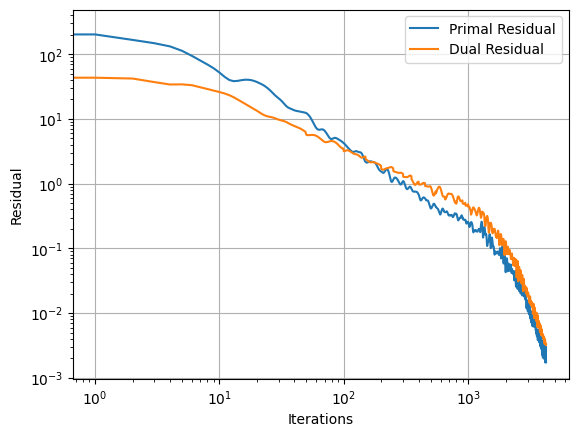

In [10]:
plt.loglog(history_admm.power, label='Primal Residual')
plt.loglog(history_admm.dual_power, label='Dual Residual')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.legend()

In [12]:
pypsa_cone_params, pypsa_data, pypsa_cones = get_standard_conic_problem(pypsa_problem, solver=cp.CLARABEL)

In [14]:
# Solve Conic PyPSA using Zap
machine = 'cuda'
dtype = torch.float32
cone_bridge_pypsa = ConeBridge(pypsa_cone_params, ruiz_iters = 0)
cone_admm_devices_pypsa = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge_pypsa.devices]
cone_admm = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    num_iterations=10000,
)
start_time = time.time()
cone_solution_admm_pypsa, cone_history_admm_pypsa = cone_admm.solve(
    net=cone_bridge_pypsa.net, devices=cone_admm_devices_pypsa, time_horizon=cone_bridge_pypsa.time_horizon
)
end_time = time.time()
solve_time = end_time - start_time
obj_val = cone_solution_admm_pypsa.objective
print(f"Objective value: {obj_val}")
print(f"Time taken: {solve_time:.4f} seconds")



Did not converge. Ran for 10000 iterations.
Objective value: -533493.8125
Time taken: 334.4888 seconds


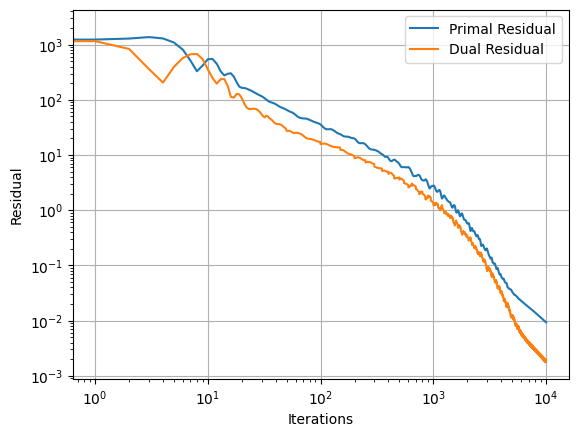

In [15]:
plt.loglog(cone_history_admm_pypsa.power, label='Primal Residual')
plt.loglog(cone_history_admm_pypsa.dual_power, label='Dual Residual')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.legend()

In [7]:
## Solve using CuPDLP
solver = pycupdlp.cupdlp()
solver.loadData(A_pypsa, c_pypsa, rhs_pypsa, lb_pypsa, ub_pypsa, neqs_pypsa)
solver.solve()

--------------------------------------------------
running scaling
- use Ruiz scaling
- use PC scaling
--------------------------------------------------
--------------------------------------------------
enter main solve loop
--------------------------------------------------

  ____ _   _ ____  ____  _     ____
 / ___| | | |  _ \|  _ \| |   |  _ \
| |   | | | | |_) | | | | |   | |_) |
| |___| |_| |  __/| |_| | |___|  __/
 \____|\___/|_|   |____/|_____|_|



--------------------------------------------------
CUPDHG Parameters:
--------------------------------------------------

    nIterLim:          2147483647
    dTimeLim (sec):    3600.00
    ifScaling:         1
    ifRuizScaling:     1
    ifL2Scaling:       0
    ifPcScaling:       1
    eLineSearchMethod: 2
    dPrimalTol:        1.0000e-04
    dDualTol:          1.0000e-04
    dGapTol:           1.0000e-04
    dFeasTol:          1.0000e-08
    eRestartMethod:    1

--------------------------------------------------

     Iter 

In [9]:
sol = solver.getSolution()
print(f"Results for OPF with T={time_horizon}")
print("Optimal Objective using CuPDLP:", sol["PrimalObj"]+offset_pypsa)
print("Optimal Objective using Zap:", solution_admm.objective)
print(f" Zap Time taken: {solve_time:.4f} seconds")
print(f" CuPDLP Time taken: {sol["solve_time"]:.4f} seconds")



Results for OPF with T=720
Optimal Objective using CuPDLP: 6452.680477552582
Optimal Objective using Zap: 6503.264580565545
 Zap Time taken: 25.9900 seconds
 CuPDLP Time taken: 120.7635 seconds


In [10]:
sol

{'x': array([0.00895831, 0.        , 0.        , ..., 0.0005    , 0.001     ,
        0.12099999]),
 'y': array([0.25176705, 0.25150926, 0.2516912 , ..., 0.        , 0.        ,
        0.        ]),
 'iters': 286480,
 'solve_time': 120.76346588134766,
 'scaling_time': 0.3887369632720947,
 'presolve_time': 0.0,
 'PrimalObj': -534625.5946924519,
 'DualObj': -534625.6267709984,
 'DualityGap': 0.03207854647189379,
 'Comp': 0.0,
 'PrimalFeas': 0.00048180342024969496,
 'DualFeas': 0.0006778116483311018,
 'PrimalObjAvg': -534625.5970541702,
 'DualObjAvg': -534625.5978746339,
 'DualityGapAvg': 0.0008204636396840215,
 'CompAvg': 0.0,
 'PrimalFeasAvg': 0.00033770122294500896,
 'DualFeasAvg': 0.0002708812389206013}

In [4]:
## Create a large problem that is valid using max flow benchmark set 
n = 1000000
base_seed = 42
max_flow_benchmark = MaxFlowBenchmarkSet(num_problems=1, n=n, base_seed=base_seed)

for prob in max_flow_benchmark:
    problem = prob
num_variables = sum(np.prod(var.shape) for var in problem.variables())
num_constraints = sum(constraint.size for constraint in problem.constraints)
nnz = num_variables # This is the actual number of edges
total_possible_edges = float(n*(n - 1))
density = nnz/total_possible_edges
sparsity = 1 - density
print(f'Generated a valid network with {n} nodes using starting seed {base_seed}')
print(f"Actual Number of Edges: {nnz}")
print(f"Total Possible Edges: {total_possible_edges}")
print(f"Graph sparsity: {sparsity}")
print(f"Graph density: {density}")
print(f"Number of Variables: {num_variables}")
print(f"Number of Constraints: {num_constraints}")

Generated a valid network with 1000000 nodes using starting seed 42
Actual Number of Edges: 27630033
Total Possible Edges: 999999000000.0
Graph sparsity: 0.9999723699393699
Graph density: 2.763006063006063e-05
Number of Variables: 27630033
Number of Constraints: 28630033


In [5]:
cone_params, data, cones = get_standard_conic_problem(problem, solver=cp.CLARABEL)

In [20]:
def stack_cvxpy_colwise(instance_list):
    # grab one problem as template
    base = get_standard_conic_problem(instance_list[0])[0]
    m, n = base["A"].shape
    T = len(instance_list)

    b_mat = np.zeros((m, T))
    c_mat = np.zeros((n, T))

    for j, prob in enumerate(instance_list):
        cone, *_ = get_standard_conic_problem(prob)
        assert (cone["A"] != base["A"]).nnz == 0   # sparsity identical
        b_mat[:, j] = cone["b"]                    # columns = scenarios
        c_mat[:, j] = cone["c"]

    cone_params = dict(P=base["P"], A=base["A"], b=b_mat, c=c_mat, K=base["K"])
    return cone_params


In [21]:
## Create a hack-y batch for testing
cone_params_batched = stack_cvxpy_colwise([problem]*20)
cone_params_batched

{'P': None,
 'A': <Compressed Sparse Column sparse matrix of dtype 'float64'
 	with 551979 stored elements and shape (193993, 183993)>,
 'b': array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [5.e+00, 5.e+00, 5.e+00, ..., 5.e+00, 5.e+00, 5.e+00],
        [5.e+00, 5.e+00, 5.e+00, ..., 5.e+00, 5.e+00, 5.e+00],
        [1.e+04, 1.e+04, 1.e+04, ..., 1.e+04, 1.e+04, 1.e+04]]),
 'c': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [-1., -1., -1., ..., -1., -1., -1.]]),
 'K': {'z': 10000, 'l': 183993, 'q': [], 'ep': 0, 's': []}}

In [7]:
# Solve a single max flow instance
machine = 'cuda'
dtype = torch.float32
cone_bridge = ConeBridge(cone_params, ruiz_iters = 0)
cone_admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge.devices]
cone_admm = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    # alpha=1.6,
    # tau=2,
    num_iterations=10000,
)
start_time = time.time()
cone_solution_admm, cone_history_admm = cone_admm.solve(
    net=cone_bridge.net, devices=cone_admm_devices, time_horizon=cone_bridge.time_horizon
)
end_time = time.time()
zap_solve_time = end_time - start_time
obj_val = cone_solution_admm.objective
print(f"Objective value: {obj_val}")
print(f"Time taken: {zap_solve_time:.4f} seconds")



ADMM converged in 7653 iterations.
Objective value: -117.00125885009766
Time taken: 14.6509 seconds


In [55]:
# Solve the batched max flow instance
machine = 'cuda'
dtype = torch.float32
cone_bridge_batched = ConeBridge(cone_params_batched, ruiz_iters = 0)
cone_admm_devices_batched = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge_batched.devices]
cone_admm = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    num_iterations=10000,
)
start_time = time.time()
cone_solution_admm_batched, cone_history_admm_batched = cone_admm.solve(
    net=cone_bridge_batched.net, devices=cone_admm_devices_batched, time_horizon=cone_bridge_batched.time_horizon
)
end_time = time.time()
solve_time = end_time - start_time
obj_val = cone_solution_admm_batched.objective
print(f"Objective value: {obj_val}")
print(f"Time taken: {solve_time:.4f} seconds")



Did not converge. Ran for 10000 iterations.
Objective value: -3172.916748046875
Time taken: 43.1054 seconds


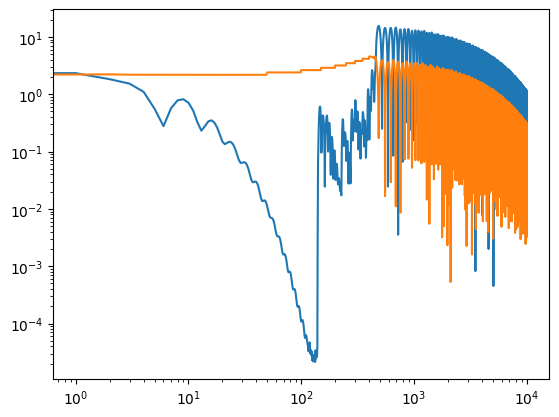

In [56]:
plt.loglog(cone_history_admm_batched.power)
plt.loglog(cone_history_admm_batched.dual_power)

In [50]:
start_time = time.time()
problem.solve(solver=cp.PDLP)
end_time = time.time()
pdlp_solve_time = end_time - start_time
print(f"Objective value: {problem.value}")
print(f"Time taken: {pdlp_solve_time:.4f} seconds")

Objective value: -157.99989608772538
Time taken: 3.4517 seconds


In [6]:
import subprocess

# Start logging GPU usage every 100ms
gpu_log_file = "gpu_log.csv"
monitor = subprocess.Popen(
    [
        "nvidia-smi",
        "--query-gpu=timestamp,index,name,utilization.gpu,utilization.memory,memory.used,memory.total",
        "--format=csv",
        "-lms", "100"
    ],
    stdout=open(gpu_log_file, "w")
)


In [5]:
# Solve single max flow with CuPDLP
A_mflow, c_mflow, rhs_mflow, lb_mflow, ub_mflow, neqs_mflow, offset_mflow = osqp_to_cupdlp(problem)


In [7]:
## Solve using CuPDLP
solver = pycupdlp.cupdlp()
solver.loadData(A_mflow, c_mflow, rhs_mflow, lb_mflow, ub_mflow, neqs_mflow)
solver.solve()

--------------------------------------------------
running scaling
- use Ruiz scaling
- use PC scaling
--------------------------------------------------
--------------------------------------------------
enter main solve loop
--------------------------------------------------

  ____ _   _ ____  ____  _     ____
 / ___| | | |  _ \|  _ \| |   |  _ \
| |   | | | | |_) | | | | |   | |_) |
| |___| |_| |  __/| |_| | |___|  __/
 \____|\___/|_|   |____/|_____|_|



--------------------------------------------------
CUPDHG Parameters:
--------------------------------------------------

    nIterLim:          2147483647
    dTimeLim (sec):    3600.00
    ifScaling:         1
    ifRuizScaling:     1
    ifL2Scaling:       0
    ifPcScaling:       1
    eLineSearchMethod: 2
    dPrimalTol:        1.0000e-04
    dDualTol:          1.0000e-04
    dGapTol:           1.0000e-04
    dFeasTol:          1.0000e-08
    eRestartMethod:    1

--------------------------------------------------

     Iter 

In [8]:
monitor.terminate()
monitor.wait()


0

In [20]:
import pandas as pd
df = pd.read_csv(gpu_log_file)
df[' utilization.gpu [%]'] = pd.to_numeric(df[' utilization.gpu [%]'].str.replace('%', '').str.strip())
df.tail(100)


,timestamp,index,name,utilization.gpu [%],utilization.memory [%],memory.used [MiB],memory.total [MiB]
152,2025/06/16 18:23:24.543,0,NVIDIA A100-SXM4-80GB,0,0 %,2869 MiB,81920 MiB
153,2025/06/16 18:23:24.643,0,NVIDIA A100-SXM4-80GB,0,0 %,2869 MiB,81920 MiB
154,2025/06/16 18:23:24.743,0,NVIDIA A100-SXM4-80GB,0,0 %,2869 MiB,81920 MiB
155,2025/06/16 18:23:24.843,0,NVIDIA A100-SXM4-80GB,0,0 %,2869 MiB,81920 MiB
156,2025/06/16 18:23:24.944,0,NVIDIA A100-SXM4-80GB,0,0 %,2869 MiB,81920 MiB
...,...,...,...,...,...,...,...
247,2025/06/16 18:23:34.061,0,NVIDIA A100-SXM4-80GB,0,0 %,2871 MiB,81920 MiB
248,2025/06/16 18:23:34.161,0,NVIDIA A100-SXM4-80GB,0,0 %,2871 MiB,81920 MiB
249,2025/06/16 18:23:34.261,0,NVIDIA A100-SXM4-80GB,0,0 %,2871 MiB,81920 MiB
250,2025/06/16 18:23:34.361,0,NVIDIA A100-SXM4-80GB,0,0 %,2871 MiB,81920 MiB


In [13]:
df.columns 

Index(['timestamp', ' index', ' name', ' utilization.gpu [%]',
       ' utilization.memory [%]', ' memory.used [MiB]', ' memory.total [MiB]'],
      dtype='object')

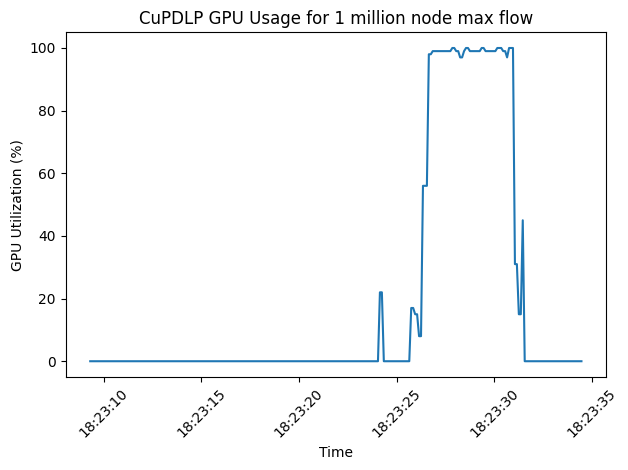

In [22]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
plt.plot(df['timestamp'], df[' utilization.gpu [%]'])
plt.ylabel("GPU Utilization (%)")
plt.xlabel("Time")
plt.title("CuPDLP GPU Usage for 1 million node max flow")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [53]:
sol = solver.getSolution()
print("Results for Single Max Flow")
print("Optimal Objective using CuPDLP:", sol["PrimalObj"]+offset_mflow)
print("Optimal Objective using PDLP:", problem.value)
print("Optimal Objective using Zap:", cone_solution_admm.objective)
print(f" CuPDLP Time taken: {sol["solve_time"]:.4f} seconds")
print(f" PDLP Time taken: {pdlp_solve_time:.4f} seconds")
print(f" Zap Time taken: {zap_solve_time:.4f} seconds")




Results for Single Max Flow
Optimal Objective using CuPDLP: -158.00014563841762
Optimal Objective using PDLP: -157.99989608772538
Optimal Objective using Zap: -158.0017852783203
 CuPDLP Time taken: 0.0781 seconds
 PDLP Time taken: 3.4517 seconds
 Zap Time taken: 16.8871 seconds


In [59]:
## Run CuPDLP on batched problem instance
batched_problem = cone_bridge_batched.net.dispatch(cone_bridge_batched.devices, time_horizon=20, solver=cp.CLARABEL, add_ground=False, return_problem_only=True)
A_batched, c_batched, rhs_batched, lb_batched, ub_batched, neqs_batched, offset_batched = osqp_to_cupdlp(batched_problem)


/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:407: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


: 